## Notebook for Joanito cancer epithelial cells data integration and batch correction `scVI`

- **Developed by**: Anna Maguza
- **Institute of Computational Biology - Computational Health Centre - Helmholtz Munich**
- 2nd Juni 2023

### Load required modules

In [1]:
import sys
import scvi
import torch
import anndata
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import seaborn as sns

import numpy as np
import scipy as sp
import pandas as pd
import scanpy as sc
import numpy.random as random


from umap import UMAP
import warnings; warnings.simplefilter('ignore')

import matplotlib.pyplot as plt

Global seed set to 0
/Users/anna.maguza/miniconda3/envs/scvi_env/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/Users/anna.maguza/miniconda3/envs/scvi_env/lib/python3.9/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a future release. Please use `register_pytree_with_keys()` instead.
  jax.tree_util.register_keypaths(data_clz, keypaths)
/Users/anna.maguza/miniconda3/envs/scvi_env/lib/python3.9/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a future release. Please use `register_pytree_with_keys()` instead.
  jax.tree_util.register_keypaths(data_clz, keypaths)
/Users/anna.maguza/miniconda3/envs/scvi_env/lib/python3.9/site-packages/flax/struct.py:132: FutureWarnin

In [2]:
%matplotlib inline
matplotlib.rcParams["pdf.fonttype"] = 42
matplotlib.rcParams["ps.fonttype"] = 42

In [3]:
torch.cuda.is_available()

False

In [4]:
torch.set_float32_matmul_precision('medium')

In [5]:
sc.settings.verbosity = 3
sc.logging.print_versions()
sc.settings.set_figure_params(dpi = 180, color_map = 'magma_r', dpi_save = 300, vector_friendly = True, format = 'svg')

-----
anndata     0.8.0
scanpy      1.9.3
-----
PIL                         9.4.0
absl                        NA
appnope                     0.1.2
asttokens                   NA
attr                        22.2.0
backcall                    0.2.0
beta_ufunc                  NA
binom_ufunc                 NA
brotli                      NA
certifi                     2022.12.07
cffi                        1.15.1
charset_normalizer          2.1.1
chex                        0.1.6
colorama                    0.4.6
comm                        0.1.2
contextlib2                 NA
cycler                      0.10.0
cython_runtime              NA
dateutil                    2.8.2
debugpy                     1.5.1
decorator                   5.1.1
defusedxml                  0.7.1
docrep                      0.3.2
entrypoints                 0.4
executing                   0.8.3
flax                        0.6.1
fsspec                      2023.3.0
h5py                        3.8.0
hypergeom_uf

In [6]:
arches_params = dict(
    use_layer_norm = "both",
    use_batch_norm = "none",
    encode_covariates = True,
    dropout_rate = 0.2,
    n_layers = 2,
)

In [7]:
def X_is_raw(adata):
    return np.array_equal(adata.X.sum(axis=0).astype(int), adata.X.sum(axis=0))

### Read in datasets

In [8]:
input = '/Users/anna.maguza/Desktop/Data/Processed_datasets/Cancer_dataset_integration/Labels_transfer/scBalance/Joanito_predicted_labels_with_scBalance_7000.h5ad'
adata = sc.read(input)

In [9]:
X_is_raw(adata)

False

In [10]:
# Return to the raw counts for the integration
adata = adata.raw.to_adata()

In [11]:
X_is_raw(adata)

True

In [12]:
adata.layers['counts'] = adata.X.copy()

# Calculate 5000 HVGs
sc.pp.highly_variable_genes(
    adata,
    flavor = "seurat_v3",
    n_top_genes = 5000,
    layer = "counts",
    batch_key = "Library_Preparation_Protocol",
    subset = True,
    span = 1
)

If you pass `n_top_genes`, all cutoffs are ignored.
extracting highly variable genes
--> added
    'highly_variable', boolean vector (adata.var)
    'highly_variable_rank', float vector (adata.var)
    'means', float vector (adata.var)
    'variances', float vector (adata.var)
    'variances_norm', float vector (adata.var)


### Run Integration with scVI

In [13]:
adata = adata.copy()
scvi.model.SCVI.setup_anndata(adata, 
                              layer = "counts", 
                              labels_key = "Predicted Label", 
                              categorical_covariate_keys = ["Sample_ID"],
                              continuous_covariate_keys = ["n_genes_by_counts", "total_counts"])

In [14]:
scvi_model = scvi.model.SCVI(adata, n_latent = 50, n_layers = 3, dispersion = 'gene-batch', gene_likelihood = 'nb')

In [15]:
scvi_model.train()

GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Epoch 224/224: 100%|██████████| 224/224 [34:21<00:00,  9.26s/it, loss=725, v_num=1] 

`Trainer.fit` stopped: `max_epochs=224` reached.


Epoch 224/224: 100%|██████████| 224/224 [34:21<00:00,  9.20s/it, loss=725, v_num=1]


In [16]:
adata.obsm["X_scVI"] = scvi_model.get_latent_representation()

### Integration with scANVI

In [17]:
scanvi_model = scvi.model.SCANVI.from_scvi_model(
    scvi_model,
    adata=adata,
    labels_key="Predicted Label",
    unlabeled_category="Unknown",
)

In [19]:
scanvi_model.train()

INFO     Training for 10 epochs.                                                                                   


GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Epoch 10/10: 100%|██████████| 10/10 [02:26<00:00, 14.32s/it, loss=786, v_num=1]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 10/10: 100%|██████████| 10/10 [02:26<00:00, 14.64s/it, loss=786, v_num=1]


In [20]:
adata.obsm["X_scANVI"] = scanvi_model.get_latent_representation(adata)

In [21]:
# Save the results
adata.write('/Users/anna.maguza/Desktop/Data/Processed_datasets/Cancer_dataset_integration/Datasets integration/Joanito_epithelial/Integrated_Joanito_epithelial_datasets_5000_QC_batch.h5ad')

### UMAP calculation

In [22]:
sc.pp.neighbors(adata, use_rep = "X_scVI", n_neighbors = 50, metric = 'minkowski')

computing neighbors
Epoch 3/10:  20%|██        | 2/10 [03:01<12:04, 90.61s/it, loss=801, v_num=1]
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:12)


In [23]:
sc.tl.umap(adata, min_dist = 0.4, spread = 4, random_state = 1712)

computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:20)


In [24]:
adata

AnnData object with n_obs × n_vars = 35714 × 5000
    obs: 'nFeature_RNA', 'pct_counts_mito', 'Sample_ID', 'Donor_ID', 'sample.origin', 'dataset_x', 'Cell Type', 'iCMS', 'msi', 'dataset_y', 'Sex', 'Tumor Stage', 'MSS/MSI', 'Location', 'Side', 'Group Stage', 'Stage TNM', 'iCMS.transcriptomic', 'iCMS.inferCNV', 'KRAS', 'BRAF', 'TP53', 'APC', 'PIK3CA', 'LymphNode', 'Normal', 'Tumor', 'CMS', 'Age_group', 'Study_name', 'Diagnosis', 'n_genes_by_counts', 'total_counts', 'Library_Preparation_Protocol', 'doublet_scores', 'predicted_doublets', 'doublet_info', 'Predicted Label', '_scvi_batch', '_scvi_labels'
    var: 'feature_types', 'genome', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'highly_variable_nbatches'
    uns: 'log1p', 'hvg', '_scvi_uuid', '_scvi_manager_uuid', 'neighbors', 'umap'
    obsm: '_scvi_extra_categorical_covs', '_scvi_extra_continuous_covs', 'X_scVI', 'X_scANVI', 'X_umap'
    layers: 'counts'
    obsp: 'distances', 'connectivities'

In [25]:
# rename 'predicted labels' column in obs to 'predicted labels scBalance'
adata.obs.rename(columns = {'Predicted Label': 'Predicted_Label'}, inplace = True)

In [26]:
adata.obs = adata.obs.rename(columns={"Gender": "Sex"})

In [ ]:
def diagnosis_mapping(label):
    if label.startswith('T1'):
        return 'Colorectal cancer, Stage I'
    elif label.startswith('T2'):
        return 'Colorectal cancer, Stage II'
    elif label.startswith('T3'):
        return 'Colorectal cancer, Stage III'
    elif label.startswith('T4'):
        return 'Colorectal cancer, Stage IV'
    elif label.startswith('mpT3'):
        return 'Colorectal cancer, Stage mpIII'
    elif label.startswith('pT1'):
        return 'Colorectal cancer, Stage pI'
    elif label.startswith('pT2'):
        return 'Colorectal cancer, Stage pII'
    elif label.startswith('pT3'):
        return 'Colorectal cancer, Stage pIII'
    elif label.startswith('pT4'):
        return 'Colorectal cancer, Stage pIV'
    elif label.startswith('ypT3'):
        return 'Colorectal cancer, Stage ypIII'
    else:
        return label  # leave the label unchanged if it doesn't match any of the above
    

adata.obs['Diagnosis'] = adata.obs['Stage TNM']

adata.obs['Diagnosis'] = adata.obs['Diagnosis'].apply(diagnosis_mapping)

In [ ]:
sc.set_figure_params(dpi=300)
sc.pl.umap(adata, frameon = False, color = ['Predicted_Label', 'Diagnosis', 'Sample_ID', 'Library_Preparation_Protocol', 'Location', 'Donor_ID', 'Sex', 'MSS/MSI', 'n_genes_by_counts', 'total_counts', 'pct_counts_mito', 'doublet_info'], size = 1, legend_fontsize = 5, ncols = 3)

In [28]:
# Save the results
adata.write('/Users/anna.maguza/Desktop/Data/Processed_datasets/Cancer_dataset_integration/Datasets integration/Joanito_epithelial/Integrated_Joanito_epithelial_datasets_5000.h5ad')

### scIB metrics calculation

In [1]:
import anndata as an
import scanpy as sc
from rich import print
import scib
import scib.metrics
import numpy as np

from scvi_colab import install
from scib_metrics.benchmark import Benchmarker

In [4]:
adata = sc.read_h5ad('/Users/anna.maguza/Desktop/Data/Processed_datasets/Cancer_dataset_integration/Datasets integration/Joanito_epithelial/Integrated_Joanito_epithelial_datasets_5000.h5ad')

/Users/anna.maguza/miniconda3/envs/scib_env2/lib/python3.9/site-packages/anndata/_io/specs/registry.py:235: OldFormatWarning: Element '/uns/MSS' was written without encoding metadata.
  return self.callback(read_func, elem.name, elem, iospec=get_spec(elem))


In [5]:
bm = Benchmarker(
    adata,
    batch_key="Sample_ID",
    label_key="Predicted_Label",
    embedding_obsm_keys=['X_scANVI', 'X_scVI'],
    n_jobs=-1,
)
bm.benchmark()

Computing neighbors:   0%|          | 0/2 [00:00<?, ?it/s]/Users/anna.maguza/miniconda3/envs/scib_env2/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Embeddings:   0%|          | 0/2 [00:00<?, ?it/s]

INFO     Enterochromaffin cells consists of a single batch or is too small. Skip.                                  
INFO     L cells consists of a single batch or is too small. Skip.                                                 
INFO     Microfold cell consists of a single batch or is too small. Skip.                                          


/Users/anna.maguza/miniconda3/envs/scib_env2/lib/python3.9/site-packages/scib_metrics/_pcr_comparison.py:49: UserWarning: PCR comparison score is negative, meaning variance contribution increased after integration. Setting to 0.
  warnings.warn(
Embeddings:  50%|█████     | 1/2 [01:36<01:36, 96.60s/it]

INFO     Enterochromaffin cells consists of a single batch or is too small. Skip.                                  
INFO     L cells consists of a single batch or is too small. Skip.                                                 
INFO     Microfold cell consists of a single batch or is too small. Skip.                                          


/Users/anna.maguza/miniconda3/envs/scib_env2/lib/python3.9/site-packages/scib_metrics/_pcr_comparison.py:49: UserWarning: PCR comparison score is negative, meaning variance contribution increased after integration. Setting to 0.
  warnings.warn(
Embeddings: 100%|██████████| 2/2 [03:09<00:00, 94.60s/it]


/Users/anna.maguza/miniconda3/envs/scib_env2/lib/python3.9/site-packages/scanpy/_settings.py:447: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  IPython.display.set_matplotlib_formats(*ipython_format)


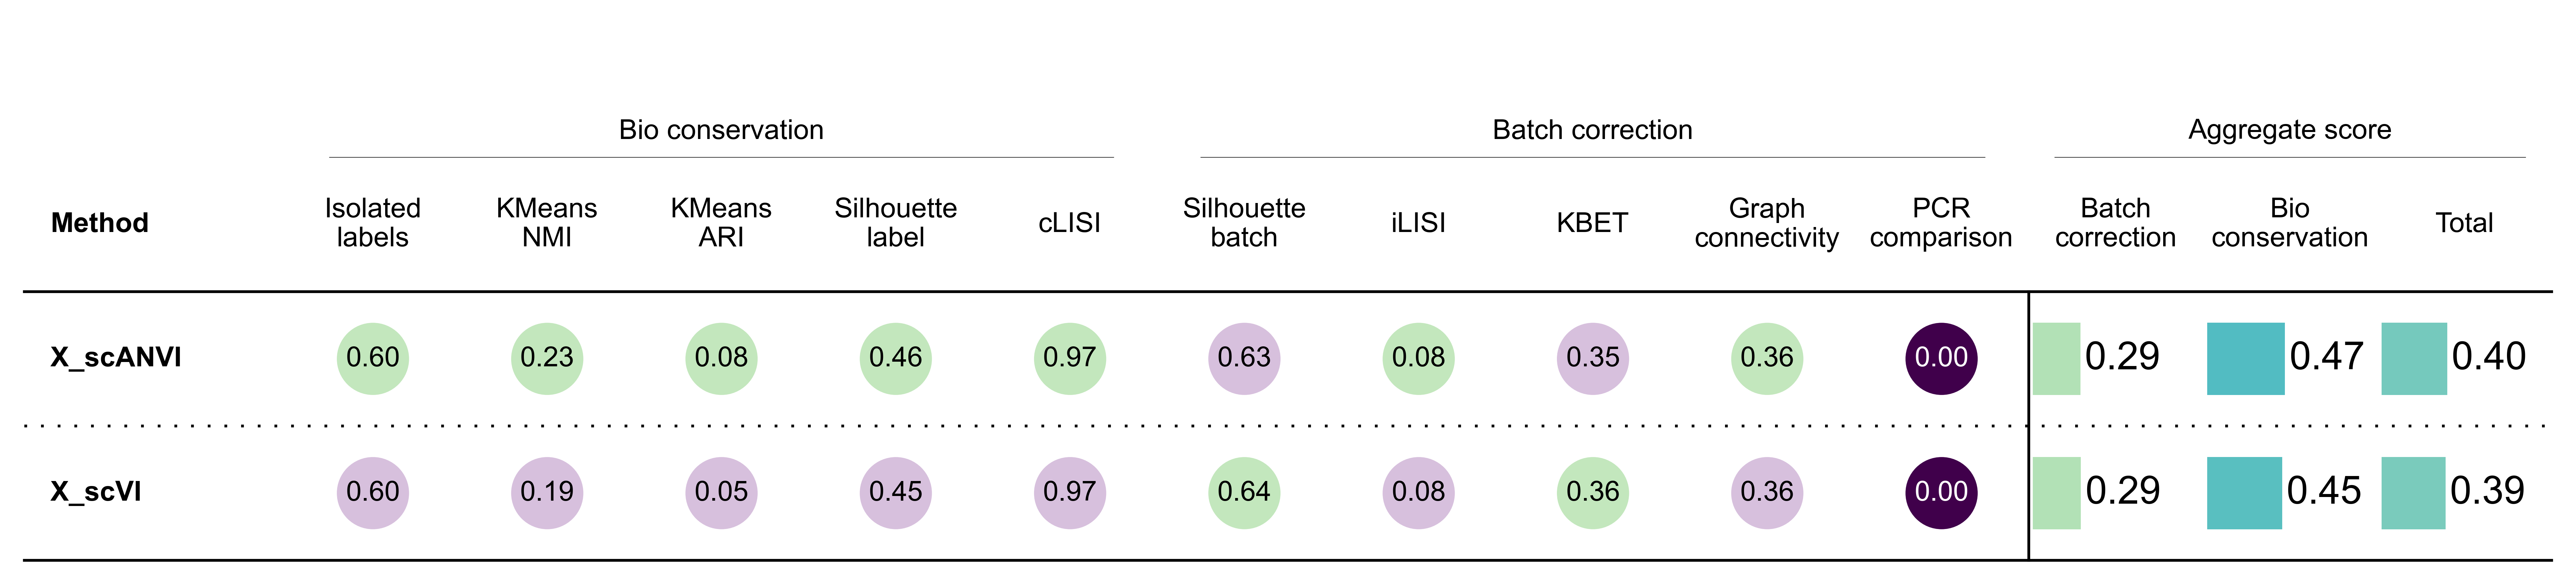

In [6]:
sc.set_figure_params(dpi=300, figsize = (4, 10))
bm.plot_results_table(min_max_scale=False)